# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

# Hackathon 2: Voice commands based food ordering system

### Setup Steps

In [0]:
#@title Please enter your registration id to start: (e.g. P181900101) { run: "auto", display-mode: "form" }
Id = "" #@param {type:"string"}


In [0]:
#@title Please enter your password (normally your phone number) to continue: { run: "auto", display-mode: "form" }
password = "7829403732" #@param {type:"string"}


In [0]:
#@title Run this cell to complete the setup for this Notebook

from IPython import get_ipython
ipython = get_ipython()
  
notebook="BLR_M2_Hackathon" #name of the notebook

def setup():
#  ipython.magic("sx pip3 install torch")
    ipython.magic("sx wget https://cdn.talentsprint.com/aiml/Experiment_related_data/Week8/Hackathon2/Noisy_data.zip")
    ipython.magic("sx wget https://cdn.talentsprint.com/aiml/Experiment_related_data/Week8/Hackathon2/studio_data.zip")
    ipython.magic("sx wget https://cdn.talentsprint.com/aiml/Experiment_related_data/Week8/Hackathon2/Record_audio.py")
    ipython.magic("sx wget https://cdn.talentsprint.com/aiml/Experiment_related_data/Week8/Hackathon2/net_speech_89.pt")
    ipython.magic("sx unzip studio_data.zip")
    ipython.magic("sx unzip Noisy_data.zip")
    ipython.magic("sx pip install torch torchvision")
    ipython.magic("sx pip install librosa")
    print ("Setup completed successfully")
    return

def submit_notebook():
    
    ipython.magic("notebook -e "+ notebook + ".ipynb")
    
    import requests, json, base64

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:        
        print(r["err"])
        return None        
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getComplexity() and getAdditional() and getConcepts():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional, 
              "concepts" : Concepts, "record_id" : submission_id, 
              "id" : Id, "file_hash" : file_hash, "notebook" : notebook}

      r = requests.post(url, data = data)
      print("Your submission is successful. Ref:", submission_id)
      return submission_id
    else: submission_id
    

def getAdditional():
  try:
    if Additional: return Additional      
    else: raise NameError('')
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None
  
def getConcepts():
  try:
    return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None

def getId():
  try: 
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup 
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
  
else:
  print ("Please complete Id and Password cells before running setup")



  [PIL]
You must restart the runtime in order to use newly installed versions.
Setup completed successfully


In [0]:
!ls -l Noisy_data

total 189424
-rwxr-xr-x 1 root root 14380 Jul  8  2018 0_1_0.wav
-rwxr-xr-x 1 root root 14380 Jul  7  2018 0_1_105.wav
-rwxr-xr-x 1 root root 14380 Jul  8  2018 0_1_108.wav
-rwxr-xr-x 1 root root 14380 Jul  7  2018 0_1_117.wav
-rwxr-xr-x 1 root root 14380 Jul  8  2018 0_1_12.wav
-rwxr-xr-x 1 root root 14380 Jul  7  2018 0_1_21.wav
-rwxr-xr-x 1 root root 14380 Jul  8  2018 0_1_24.wav
-rwxr-xr-x 1 root root 14380 Jul  7  2018 0_1_33.wav
-rwxr-xr-x 1 root root 14380 Jul  8  2018 0_1_36.wav
-rwxr-xr-x 1 root root 14380 Jul  7  2018 0_1_45.wav
-rwxr-xr-x 1 root root 14380 Jul  8  2018 0_1_48.wav
-rwxr-xr-x 1 root root 14380 Jul  7  2018 0_1_57.wav
-rwxr-xr-x 1 root root 14380 Jul  8  2018 0_1_60.wav
-rwxr-xr-x 1 root root 14380 Jul  7  2018 0_1_69.wav
-rwxr-xr-x 1 root root 14380 Jul  8  2018 0_1_72.wav
-rwxr-xr-x 1 root root 14380 Jul  7  2018 0_1_81.wav
-rwxr-xr-x 1 root root 14380 Jul  8  2018 0_1_84.wav
-rwxr-xr-x 1 root root 14380 Jul  7  2018 0_1_93.wav
-rwxr-xr-x 1 root root 14380 Ju

In [0]:
import torch
from torch.autograd import Variable
import numpy as np
import librosa
import os
import warnings
from time import sleep
import sys
warnings.filterwarnings('ignore')

In [0]:
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

## Pretrained Network for deep features


The following function contains code to load a pre-trained network to produces deep features for the audio sample. This network is trained with delta MFCC features of mono channel 8000 bit rate audio sample.

In [0]:
def get_network():

    net = torch.nn.Sequential()

    saved_net = torch.load("net_speech_89.pt").cpu()

    for index, module in enumerate(saved_net):
        net.add_module("layer"+str(index),module)
        if (index+1)%17 == 0 :
            break
    return net

##Obtaining Features from Audio samples
Generate features from a audio sample of '.wav' format
* Generate Delta MFCC features of order 1 and 2 
* Passes them through the above mentioned deep neural net
* the obtained deep features are returned

Parameters: Filepath (path of audio sample),
                       sr (sampling rate, all the samples provided are of 8000 bitrate)
         
  Caution: Do not change the default parameters

In [0]:
30*15

450

In [0]:
def get_features(filepath, sr=8000, n_mfcc=30, n_mels=128, frames = 15):
    
    
    y, sr = librosa.load(filepath, sr=sr)
    D = np.abs(librosa.stft(y))**2
    S = librosa.feature.melspectrogram(S=D)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_S = librosa.power_to_db(S,ref=np.max)
    features = librosa.feature.mfcc(S=log_S, n_mfcc=n_mfcc)
    #print(features.shape[1])
    if features.shape[1] < frames :
        features = np.hstack((features, np.zeros((n_mfcc, frames - features.shape[1]))))
    elif features.shape[1] > frames:
        features = features[:, :frames]
    # Find 1st order delta_mfcc
    delta1_mfcc = librosa.feature.delta(features, order=1)

    # Find 2nd order delta_mfcc
    delta2_mfcc = librosa.feature.delta(features, order=2)
    
    features = np.hstack((delta1_mfcc.flatten(), delta2_mfcc.flatten()))
    #print(features.shape)
    features = features.flatten()[np.newaxis, :]
    features = Variable(torch.from_numpy(features)).float()
    deep_net = get_network()
    deep_features = deep_net(features)
    #print(features.shape)
    #print(deep_features.shape)
    #print(audio_file)
    #features.flatten()[np.newaxis, :]
    return deep_features.data.numpy().flatten()

## All the voice sample needed for training are present across the folders "Noisy_data" and "studio_data"

In [0]:
%ls

##Stage 1: 
#### Max. Marks: 5
#### Complete the code in the load_data function

* The function should take path of the folder containing audio samples as input
* It should return features of all the audio samples present in the specified folder into single array (list of lists or 2-d numpy array) and their respective labels should be returned too

In [0]:
sound_labels = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine', 'Yes', 'No']

In [0]:
def load_data(folder_path):
  features = []
  labels = []
  
  ##YOUR CODE HERE
  for fname in os.listdir(folder_path):
    
    if 'wav' not in fname:
      continue
    struct = fname.split('_')
    label = int(struct[0])
    speaker = struct[1]
    if speaker not in speakers:
      speakers.append(speaker)
    feat = get_features(folder_path + '/' + fname)
    features.append(feat)
    labels.append(label)
  return features, labels

####load data and labels from studio_data folder

In [0]:
speakers = []
studio_recorded_features, studio_recorded_labels = load_data('studio_data')

In [0]:
len(studio_recorded_labels)


In [0]:
len(studio_recorded_labels)

In [0]:
len(speakers)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(studio_recorded_features, studio_recorded_labels, random_state=42, test_size=0.20)

np.savez('studio_deep_features', X_train, X_val, y_train, y_val)

In [0]:
from google.colab import files
files.download('studio_deep_features.npz')

In [0]:
len(X_train)

6317

In [0]:
len(X_val)

2106

##Stage 2:

####Max. Marks:15

#### Train a classifier on the features obtained above

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

model = SVC(kernel='rbf', class_weight='balanced')

param_grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid, verbose=1)

grid.fit(X_train, y_train)
print(grid.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 15.8min finished


{'C': 1, 'gamma': 0.0001}


In [0]:
model = grid.best_estimator_
y_fit = model.predict(X_val)

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_fit,
                            target_names=sound_labels))

              precision    recall  f1-score   support

        Zero       0.20      0.12      0.15       243
         One       0.26      0.40      0.32       248
         Two       0.30      0.32      0.31       259
       Three       0.30      0.23      0.26       266
        Four       0.46      0.30      0.36       236
        Five       0.41      0.27      0.33       245
         Six       0.15      0.10      0.12       261
       Seven       0.31      0.29      0.30       215
       Eight       0.15      0.47      0.23       240
        Nine       0.35      0.24      0.29       271
         Yes       0.20      0.14      0.17       257
          No       0.18      0.13      0.15       219

   micro avg       0.25      0.25      0.25      2960
   macro avg       0.27      0.25      0.25      2960
weighted avg       0.27      0.25      0.25      2960



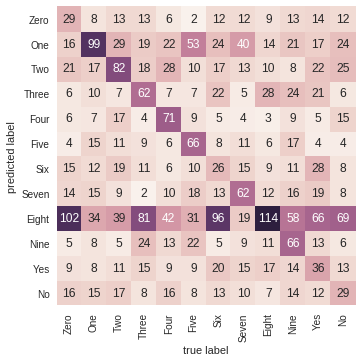

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = confusion_matrix(y_val, y_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=sound_labels,
            yticklabels=sound_labels)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [0]:
print(accuracy_score(y_val,y_fit))

0.6457739791073125


**Random Forest**

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=3,
                             random_state=0)

In [0]:
clf.fit(X_train, y_train) 
y_fit2 = clf.predict(X_val)

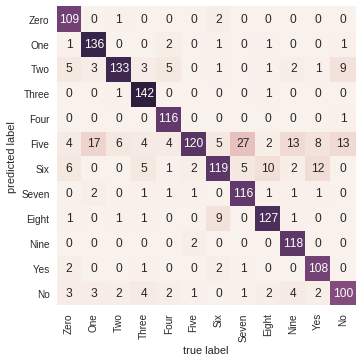

In [0]:
mat = confusion_matrix(y_val, y_fit2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=sound_labels,
            yticklabels=sound_labels)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [0]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_val,y_fit2))

0.856973293768546


In [0]:
##YOUR CODE HERE

In [0]:
save_model(clf, "studiodata_rf.sav")

####Save your model

Hint:
* Incase if you are using scikit learn model for training, you can use joblib package to save the model.
* Manually implemented models as a function or class can be saved using pickle 

In [0]:
def save_model(model, filename):
  pickle.dump(model, open(filename, 'wb'))

**Load data**

In [0]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

#### Download your trained model using the code below
* given the path of model file the following code downloads it through the browser

In [0]:
from google.colab import files
files.download('studiodata_rf.sav')


##Stage 3: (Application Deployment)

#### Max. Marks: 5M
#### Now deploy the model trained on studio_data in the sever to order food correctly. 
#### Deployment instruction are given the Hackathon documentation
#### After deploying and checking the application come back here to train on Noisy_data to generalise better in real situations

#### load data and labels from Noisy_data folder

In [0]:
noisy_data, noisy_data_labels = load_data('Noisy_data')

In [0]:
len(noisy_data)

11839

## Stage 4:
####Max. Marks:5
#### Train a classifier on the features obtained from both the Noisy_data and Studio_data

In [0]:
X_train, X_val, y_train, y_val = train_test_split(noisy_data, noisy_data_labels, random_state=42, test_size=0.20)

np.savez('noisy_deep_features', X_train, X_val, y_train, y_val)

In [0]:
from google.colab import files
files.download('noisy_deep_features.npz')

In [0]:
##YOUR CODE HERE

(11839, 50)

#### Download your trained model using the code below
* given the path of model file the following code downloads it through the browser

In [0]:
from google.colab import files
files.download('<model_file_path>')

#### Now deploy the model trained above in the sever to order food correctly. 
#### Deployment instruction are given the Hackathon documentation
#### After deploying and checking the application, record your teams data from the web application provided in the Hackathon document

In [0]:
!mkdir teamdata

Replace <YOUR_GROUP_ID> with your group id given in the lab

In [0]:
!wget -r -A .wav https://aiml-sandbox1.talentsprint.com/audio_recorder/<YOUR_GROUP_ID>/team_data/ -nH --cut-dirs=100  -P ./team_data

In [0]:
%ls

sample_data/  team_data/


In [0]:
!unzip <zip_file_name>

##Stage 5:
#### Max. Marks: 10

## Enhance the model trained with both the noisy data and studio_data to your team's voice samples

In [0]:
##YOUR CODE HERE

### Now deploy the model trained above in the sever to order food correctly. 
### Deployment instruction are given the Hackathon documentation

### Please answer the questions below to complete the experiment:

In [0]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Good and Challenging me" #@param ["Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging me", "Was Tough, but I did it", "Too Difficult for me"]


In [0]:
#@title If it was very easy, what more you would have liked to have been added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "test" #@param {type:"string"}

In [0]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["Yes", "No"]

In [0]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id =return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")